## Preparação 

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv('/datasets/taxi.csv',parse_dates=[0],index_col = [0])
df.sort_index(inplace=True)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


O DF possui apenas duas colunas, sendo a de data transformada em index, e nenhuma delas possui dados vazios.

In [4]:
# Fazendo amostragem para uma hora de diferença
df_1h = df.resample('1H').sum()
df_1h

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Análise

In [5]:
df_1h.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


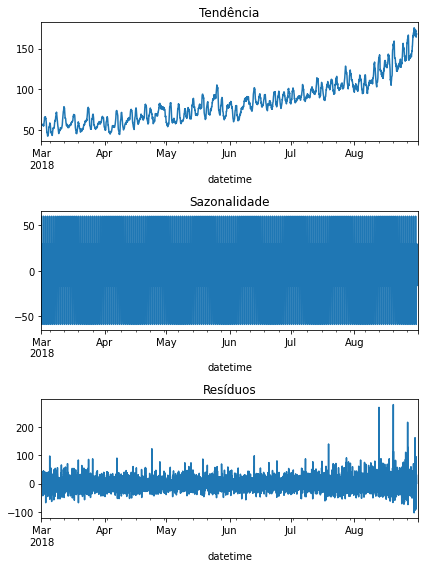

In [6]:
decomposed = seasonal_decompose(df_1h)

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Tendência')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Sazonalidade')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Resíduos')
plt.tight_layout()

Podemos perceber que a tendência é de aumento da quantidade de pedidos por hora com o decorrer dos meses, de março/2018 a agosto/2018 os números de chamados para corridas só aumentou.

<AxesSubplot:xlabel='datetime'>

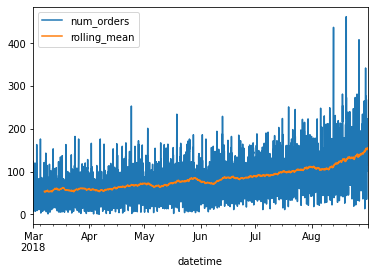

In [7]:
df_1h_mean = df_1h
df_1h_mean['rolling_mean'] = df_1h.rolling(150).mean()
df_1h_mean.plot()

Podemos ver que a média dos pedidos aumenta com o passar do tempo, e os pedidos vão aumentando com o passar dos meses. Podemos perceber que temos valores muito grandes em agosto que fogem muito da nossa média por hora.

## Treinamento

In [22]:
# Criando as características

def make_features(df_1h, max_lag, rolling_mean_size):
    df_1h['year'] = df_1h.index.year
    df_1h['month'] = df_1h.index.month
    df_1h['day'] = df_1h.index.day
    df_1h['dayofweek'] = df_1h.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df_1h['lag_{}'.format(lag)] = df_1h['num_orders'].shift(lag)

    df_1h['rolling_mean'] = df_1h['num_orders'].shift().rolling(rolling_mean_size).mean()

In [23]:
# Aplicando a funçõa
make_features(df_1h, 4, 4)

Nesses dois últimos comandos, criei novas características para o modelo que vão ajudar na previsão. São elas:
* O ano 
* O mês
* O dia
* O dia da semana

Fiz isso para podermos ter um detalhamento maior de todos os fatores que podem afetar nosso modelo.

In [24]:
# Separando o conjunto de teste e treino
train, test = train_test_split(df_1h, shuffle=False, test_size=0.1)

In [25]:
# Separando as características e objetivos do modelo
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### Regressão Linear

In [12]:
# Treinando o modelo de regressão linear
model = LinearRegression()
model.fit(features_train, target_train)


LinearRegression()

### Floresta Aleatória

In [47]:
# Calibrando os hiperparâmetros
rf_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [5, 10, 15,20], 
    'max_depth': [1, 5, 10]
}

In [66]:
from sklearn.model_selection import GridSearchCV

df_1h = df_1h.dropna()
df_1h.drop(['rolling_mean'], axis=1)
X = df_1h.drop(['num_orders'], axis=1)
y = df_1h['num_orders']

rf_grid2 = GridSearchCV(rf_model, param_grid, cv=10, scoring='neg_mean_squared_error')
rf_grid2.fit(X, y)

print('Melhores hiperparâmetros: ', rf_grid2.best_params_)
print('Melhor pontuação REQM : ', np.sqrt((-1)*rf_grid2.best_score_))

Melhores hiperparâmetros:  {'max_depth': 5, 'n_estimators': 15}
Melhor pontuação REQM :  34.2495512788813


In [67]:
# Treinando o modelo 
rf_model = RandomForestRegressor(max_depth= 5, n_estimators= 15)

rf_model.fit(X, y)

RandomForestRegressor(max_depth=5, n_estimators=15)

## Testando

In [60]:
from sklearn.metrics import mean_squared_error

# Testando o modelo de regressão linear
pred_rl = model.predict(features_test)

print('REQM para o conjunto de teste:', np.sqrt(mean_squared_error(target_test, pred_rl)))


REQM para o conjunto de teste: 55.090123491546336


In [70]:
## Testando o modelo de Floresta Aleatória
rf3 = RandomForestRegressor(max_depth = 5, n_estimators=15, random_state=12345)
rf3.fit(X, y)
pred_rf3 = rf3.predict(X)
print('REQM para o conjunto todo, pois usamos cross-validation com cv=10, 10% por fold:', np.sqrt(mean_squared_error(pred_rf3, y)))

REQM para o conjunto todo, pois usamos cross-validation com cv=10, 10% por fold: 30.950390721058653


# Conclusão

Fizemos a análise dos dados, onde demostramos que existe uma tendência crescente ao longo do tempo para o número de pedidos de  taxi no aeroporto. Depois construímos 2 modelos de previsão, regressão linear e Regressão da Floresta Aleatória. Ambos os modelos performaram o REQM abaixo do proposto no exercício que era 48. E devido ao modelo de Floresta Aleatória se apresentar melhor para essa tarefa, considero que devemos utilizar o mesmo.